# Описание проекта

Создано новое приложение, компания для продвижения приложения активно вкладывается в рекламу. Несмотря на огромные вложения, последние несколько месяцев компания терпит убытки. Цель исследования — разобраться в причинах и помочь компании выйти в плюс.

Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
- лог сервера с данными об их посещениях,
- выгрузка их покупок за этот период,
- рекламные расходы.

В ходе исследования мы получим профили пользователей и на их основе
- изучим географию использования приложения,
- используемые устройтва, 
- каналы привлечения пользователей
- посчитаем экономику одного покупателя. Посчитаем CAC, ROI, LTV в разрезе устройств, стран и рекламных каналов.
- посчитаем конверсию и удержание пользователей.

После будут даны рекомендации по исправлению ситуации.

## Загрузка и предобработка данных

In [1]:
# загружаем библиотеки
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns

from plotly.offline import iplot, init_notebook_mode

In [2]:
# загружаем данные
visits = pd.read_csv('*')
orders = pd.read_csv('*')
costs = pd.read_csv('*')

# смотрим инфо, считаем дубликаты по всем таблицам
visits.info()
display('Количество дубликатов:" - {}'.format(visits.duplicated().sum()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


'Количество дубликатов:" - 0'

In [3]:
orders.info()
display('Количество дубликатов:" - {}'.format(visits.duplicated().sum()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


'Количество дубликатов:" - 0'

In [4]:
costs.info()
display('Количество дубликатов:" - {}'.format(visits.duplicated().sum()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


'Количество дубликатов:" - 0'

Пропусков и дубликатов нет- это хорошо. Названия колонок приведем к стандартному snake_case. Колонки хранящие данные о времени приведем к соответствующему типу.

In [5]:
# новый вариант
visits.columns = visits.columns.str.lower().str.replace(" ", "_")
orders.columns = orders.columns.str.lower().str.replace(" ", "_")
costs.columns = costs.columns.str.lower()

In [6]:
# преобразуем данные о времени
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date 

visits.info()
print()
print('*'*20)
orders.info()
print()
print('*'*20)
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB

********************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64

### Вывод 

В ходе предобработки пропусков и дубликатов не обнаружили. Названия колонок привели к стандартному виду. Колонки хранящие данные о времени привели к соответствующему типу.

## Функции для проведения исследования

В исследовании будут использованы функции, изученные в спринте, с помощью которых мы получим профили пользователей, посчитаем маркетинговые метрики  такие как LTV, ROI, CAC, конверсию и удержание и визуализируем их.

### Функция для создания пользовательских профилей

In [7]:
def get_profiles(sessions, orders,  ad_costs): #events,3позиция # event_names=[], 5 позиция

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
   # for event in event_names:
    #    if event in events['event_name'].unique():
     #       profiles[event] = profiles['user_id'].isin(
     #           events.query('event_name == @event')['user_id'].unique()
      #      )

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles
 

### Функция для расчёта удержания

In [8]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

### Функция для расчёта конверсии

In [9]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

### Функция для расчёта LTV и ROI

In [10]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

### Функция для сглаживания фрейма

In [11]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        if df[column].dtype == int or df[column].dtype == float:
            df[column] = df[column].rolling(window).mean() 
    return df 

### Функция для визуализации удержания

In [12]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

### функция для визуализации конверсии

In [13]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

### функция для визуализации LTV и ROI

In [14]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

## Иссследовательский анализ данных

Построим профили пользователей- таблицу с деталями первого посещения каждого пользователя, такими как источник перехода на сайт, страна, устройство. Определим минимальную и максимальную дату привлечения пользователей.

Далее на основе данных из ой таблицы выясним:
- Из каких стран приходят посетители, какие страны дают больше всего платящих пользователей;
- Какими устройствами они пользуются, с каких устройств чаще всего заходят платящие пользователи;
- По каким рекламным каналам шло привлечение, какие каналы приносят больше всего платящих пользователей.

### Профили пользователей, интервал привлечения

Для получения профилей воспользуемся функцией get_profiles, которая соберет данные из трех таблиц: visits, orders, costs и вернет нам сборную таблицу по клиентам с датами первых посещений, признаком платящих (колонка 'payer') и стоимостью привлечения(колонка 'acquisition_cost').

In [15]:
# получаем профили пользователей
profiles = get_profiles(visits, orders, costs)
# проверка результата
profiles.info()
profiles.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150008 entries, 0 to 150007
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   user_id           150008 non-null  int64         
 1   first_ts          150008 non-null  datetime64[ns]
 2   channel           150008 non-null  object        
 3   device            150008 non-null  object        
 4   region            150008 non-null  object        
 5   dt                150008 non-null  object        
 6   month             150008 non-null  datetime64[ns]
 7   payer             150008 non-null  bool          
 8   acquisition_cost  150008 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(1), int64(1), object(4)
memory usage: 10.4+ MB


,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [16]:
# посмотрим доступный интервал привлечения пользователей на основе данных из таблицы
min_analysis_date = profiles['dt'].min()
observation_date = profiles['dt'].max()  # момент анализа
display('Минимальная дата привлечения пользователей - {}'.format(min_analysis_date))
display('Максимальная дата привлечения пользователей - {}'.format(observation_date))



'Минимальная дата привлечения пользователей - 2019-05-01'

'Максимальная дата привлечения пользователей - 2019-10-27'

В нашем распоряжении данные с 01.05.2019 по 27.10.2019, но по условию считаем, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Значит момент и горизонт анализа зададим вручную.

In [17]:
horizon_days = 14  
 
observation_date = datetime(2019, 11, 1).date() 

### География пользователей

Сгруппируем ползователей по регионам и посмотрим сколько платящих и не платящих пользователей к нам пришло за всё время и их соотношение.

In [18]:
# строим сводную таблицу по региону
profiles_pivot_region = profiles.pivot_table(
    index=['region'], 
    columns='payer', 
    values = 'user_id', 
    aggfunc='count'
)
# добавим колонку с общим количеством пришедших пользователей по региону
profiles_pivot_region ['all_users'] = profiles.groupby('region').agg({'user_id':'count'})
# посчитаем по регионам отношение неплатящих пользователей к платящим и добавим в колонку 'ratio'
profiles_pivot_region ['ratio'] = round(profiles_pivot_region [1] / (profiles_pivot_region [0] + profiles_pivot_region [1]) * 100, 1)
# переименовываем
profiles_pivot_region.columns= ['payer_false', 'payer_true', 'all_users', 'ratio']
# сортируем 'all_users'по убыванию
profiles_pivot_region.sort_values('all_users', ascending = False)

,payer_false,payer_true,all_users,ratio
region,,,,
United States,93100,6902,100002,6.9
UK,16875,700,17575,4.0
France,16787,663,17450,3.8
Germany,14365,616,14981,4.1


Несомненный лидер США. Именно оттуда в приложение приходит большинство пользователей, как платящих так и не платящих - всего 100 тысяч за исследуемый период.Среди американцев также самый большой процент платящих - 6,9%. Из Франции и Великобритании к нам пришло примерно по 17,5 тысяч пользователей, но паказатель платящих низкий- 3,8% и 4% соответственно. Из Германии у нас 15 тысяч пользователей, платящих из них 4,1%.

### Используемые устройства

Проделаем такие же шаги для определения устройств, которыми пользуются все пользователи. 

In [19]:
# строим сводную таблицу по устройству
profiles_pivot_device = profiles.pivot_table(
    index=['device'], 
    columns='payer', 
    values = 'user_id', 
    aggfunc='count'
)
# добавим колонку с общим количеством используемых устройств
profiles_pivot_device ['all_users'] = profiles.groupby('device').agg({'user_id':'count'})
# посчитаем отношение неплатящих пользователей к платящим и добавим в колонку 'ratio'
profiles_pivot_device ['ratio'] = round(profiles_pivot_device [1] / (profiles_pivot_device [0] + profiles_pivot_device [1]) * 100, 1)
# сортируем 'all_users'по убыванию
profiles_pivot_device.sort_values('all_users', ascending = False)

payer,False,True,all_users,ratio
device,,,,
iPhone,51097,3382,54479,6.2
Android,32982,2050,35032,5.9
PC,28918,1537,30455,5.0
Mac,28130,1912,30042,6.4


Чаще всего к нам в приложение заходят с мобильных устройств 54479 пользователей с iPhone и  35032 с Android. Чуть реже с компьютеров PC - 30455 и Mac- 30042. У пользователей с iPhone и Mac самое большое соотношение платящих 6,2% и 6,4%. 

### Каналы привлечения пользователей 

Теперь посмотрим по каким рекламным каналам к нам пришли пользователи. Повторяем сборку сводной таблицы.

In [20]:
# строим сводную таблицу по каналам
profiles_pivot_channel = profiles.pivot_table(
    index=['channel'], 
    columns='payer', 
    values = 'user_id', 
    aggfunc='count'
)
# добавим колонку с общим количеством используемых устройств
profiles_pivot_channel ['all_users'] = profiles.groupby('channel').agg({'user_id':'count'})
# посчитаем отношение неплатящих пользователей к платящим и добавим в колонку 'ratio'
profiles_pivot_channel ['ratio'] = round(profiles_pivot_channel [1] / (profiles_pivot_channel [0] + profiles_pivot_channel [1]) * 100, 1)
# сортируем 'all_users'по убыванию
profiles_pivot_channel.sort_values('all_users', ascending = False)

payer,False,True,all_users,ratio
channel,,,,
organic,55279,1160,56439,2.1
FaceBoom,25587,3557,29144,12.2
TipTop,17683,1878,19561,9.6
OppleCreativeMedia,8372,233,8605,2.7
LeapBob,8291,262,8553,3.1
WahooNetBanner,8100,453,8553,5.3
RocketSuperAds,4096,352,4448,7.9
MediaTornado,4208,156,4364,3.6
YRabbit,4147,165,4312,3.8


Здорово, что почти 56,5 тысяч пользователей нашли нас сами. Хуже, что у них самый маленький процент платящих. Из платных источников самые хорошие показатели у FaceBoom	- 29144 привлеченных пользователя и самый высокий процент платящих -12,2%. Хорошо себя показал TipTop - 19561 пользователь и хороший процент платящих 9,6%. Последние 2 позиции занимают AdNonSense- 3880 пользователей и lambdaMediaAds - 2149 пользователей, но на удивление соотношение платящих у этих каналов лучше: 11,3% и 10,5%. 

Теперь пересортируем таблицу и посмотрим на аутсайдеров по проценту платящих.

In [21]:
# сортируем по возрастанию ratio
profiles_pivot_channel.sort_values('ratio')

payer,False,True,all_users,ratio
channel,,,,
organic,55279,1160,56439,2.1
OppleCreativeMedia,8372,233,8605,2.7
LeapBob,8291,262,8553,3.1
MediaTornado,4208,156,4364,3.6
YRabbit,4147,165,4312,3.8
WahooNetBanner,8100,453,8553,5.3
RocketSuperAds,4096,352,4448,7.9
TipTop,17683,1878,19561,9.6
lambdaMediaAds,1924,225,2149,10.5


Ожидаемо ползователи из органического трафика плохо конвертируются в покупателей- всего 2,1%. Из платных хуже всех показатель у OppleCreativeMedia - 2,7%. Слабенько дела идут у MediaTornado и YRabbit - 3,6 % и 3,8 %, к тому же количество привлеченных  ими пользователей невелико.		

### Вывод

В исследуемый период с 1 мая по 27 октября 2019 года к нам пришло чуть более 150 тысяч пользователей, 100 тысяч из них- американцы. Остальные, примерно в равном соотношении, Французы и Англичане(по 17,5 тысяч) и Немцы(14,9 тысяч). Чаще всего в приложение заходят с мобильных устройств, лидер- iPhone (54,5 тысяч пользователей) у него же второе место среди платящих клиентов - 6,2%. Лучше показатель платящих только у пользователей Mac-6,4% из 14,9тысячи клиентов.

Если говорить об источниках привлечения, то треть нашла нас сама, через органический трафик- 56,5 тысяч. Из платных хорошо паказал себя FaceBoom и по количеству привлеченных пользователей(29,1 тысячи) и по соотношению платящих(12,2%). TipTop тоже хорош- привлек 19,5 тысяч пользователей, с соотношением платящих -9.6%. 

Интерес вызывают AdNonSense и lambdaMediaAds. Несмотря, на то,что они привели меньше всего народу, платят эти пользователи лучше(11,3% и 10,5%). Можно подумать над увеличением закупок в этих истониках, но сначала нужно будет проверить их ROI. Остальные каналы варьируются по количеству привлеченных пользователей и степени успешности. 

Аутсайдеры-  MediaTornado и YRabbit- они привлекают немного пользователей, относительно других каналов, и эти пользователи плохо конвертируются в покупателей.Если думать над оптимизацией затрат, начать стоит с изучения этих двух каналов, конечно, после исследования показателей окупаемости.

##  Маркетинг. Экономика одного покупателя

Мы уже выяснили сколько пользователей привлекли. Теперь нужно выяснить как структурированы понесенные затраты на их привлечение. В этой части исследования ответим на следующие вопросы:
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько в среднем стоило привлечение одного покупателя из каждого источника?

Посмотрим во сколько нам обошлось привлечение клиентов. Для этого посчитаем общую сумму расходов на маркетинг. Отдельно посчитаем суммы потраченные на каждый источник и сколько стоило в среднем привлечение одного покупателя из каждого источника. Визуализируем изменения метрик во времени.

In [22]:
# считаем общую сумму потраченных средств (валюта не указана, будем считать как д.е.)

all_cost = profiles['acquisition_cost'].sum()
display(f'Общая сумма потраченных средств - {round(all_cost)} д.е.')

'Общая сумма потраченных средств - 105497 д.е.'

### Расходы на каналы привлечения

In [23]:
# строим сводную таблицу по суммме потраченных средств на каждый рекламный канал 
df_pivot_cost = profiles.pivot_table(
    index=['channel'], 
    values = 'acquisition_cost', 
    aggfunc='sum'
                                    )
df_pivot_cost.sort_values(by='acquisition_cost', ascending=False)


,acquisition_cost
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


Уже становится интереснее. Больше всего денег съел TipTop - 54751.3 д.е., но мы помним, что лидером по количеству привлеченных пользователей был FaceBoom, а на него потрачено на 12 тысяч меньше. Посмотрим как менялись затраты на каналы привлечения за всё время в динамике.

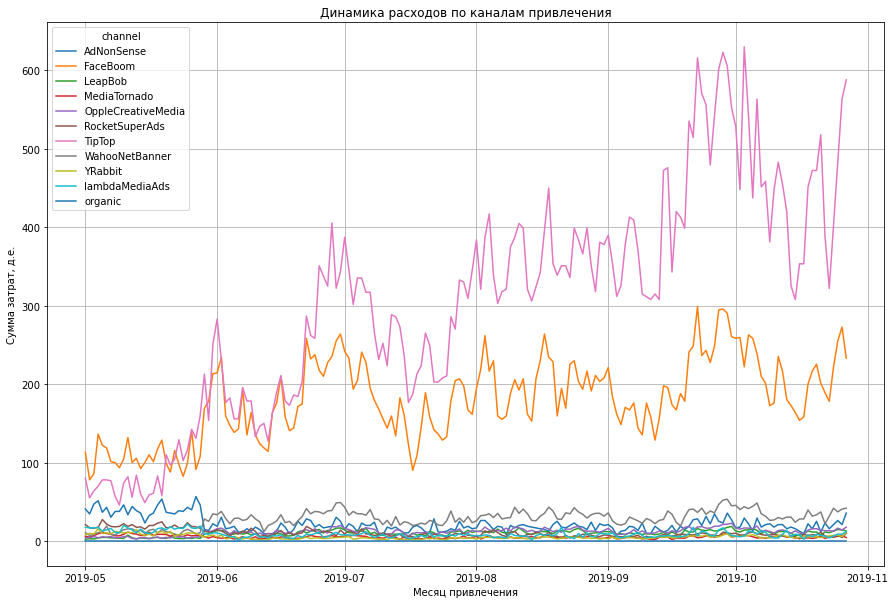

In [24]:
# строим график истории расходов по каналам привлечения  
profiles.pivot_table(
    index='dt', columns='channel', values='acquisition_cost', aggfunc='sum').plot(grid=True, figsize=(15, 10))
plt.ylabel('Сумма затрат, д.е.')
plt.xlabel('Месяц привлечения')
plt.title('Динамика расходов по каналам привлечения')
plt.show()

Буквально с первого месяца расходы на TipTop рванули вверх. На FaceBoom расходы,конечно, тоже выросли, но не так сильно. Всё еще смущает, что больше клиентов нам привел именно FaceBoom. Нужно смотреть более детально. Посчитаем во сколько нам обошлось привлечение одного клиента по каждому каналу т.е. на CAC.

###  Расчет CAC

Для начала расчитаем общий CAC. Из расходов у нас есть только таблица с расчетами на рекламу, поэтому считаем по упрощенной схеме:

CAC = Общие расходы на рекламу / Количество уникальных пользователей.

Предварительно исключим из данных органических пользователей, чтобы они не повлияли на метрику.

In [25]:
# создаем срез данных по профилям пользователей, привлеченных через рекламные каналы
profiles_without_organic = profiles.query('channel != "organic"')
# считаем средний CAC 

cac_all = costs['costs'].sum() / profiles_without_organic['user_id'].count()
display((f'Общий САС = {round(cac_all, 1)}'))

'Общий САС = 1.1'

Получили, что в среднем привлечение одного пользователя через рекламный источник обошлось в 1,1 д.е. Теперь посмотрим как эти траты распределились по источникам.

In [26]:
# считаем средний CAC по каналам привлечения

cac = (
    profiles_without_organic.groupby('channel')
    .agg({'acquisition_cost': 'mean'})
    .rename(columns={'acquisition_cost': 'cac'})
)

display(cac.sort_values('cac', ascending = False))

,cac
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


Да, пользователи пришедшие из TipTop самые дорогие. Очень дорогие. Их привлечение обходится в 2,5 раза дороже среднего CAC и  привлечения через FaceBoom. Стоит отметить AdNonSense и lambdaMediaAds- это у них был хороший % привлечения платных пользователей. Поэтому может и не совсем ужасно, что привлечение пользователей через эти каналы  стоит дороже чем из остальных. К тому же, как было видно на графике выше, буквально через месяц затраты на AdNonSense снизились и продолжают оставаться низкими.

Но посмотрим на динамику. Выясним, как меняется стоимость привлечения для каждого источника от когорты к когорте. Для этого построим сводную таблицу, по датам  и каналам привлечения пользователей, значениями  будет средний CAC, и построим график истории изменений.

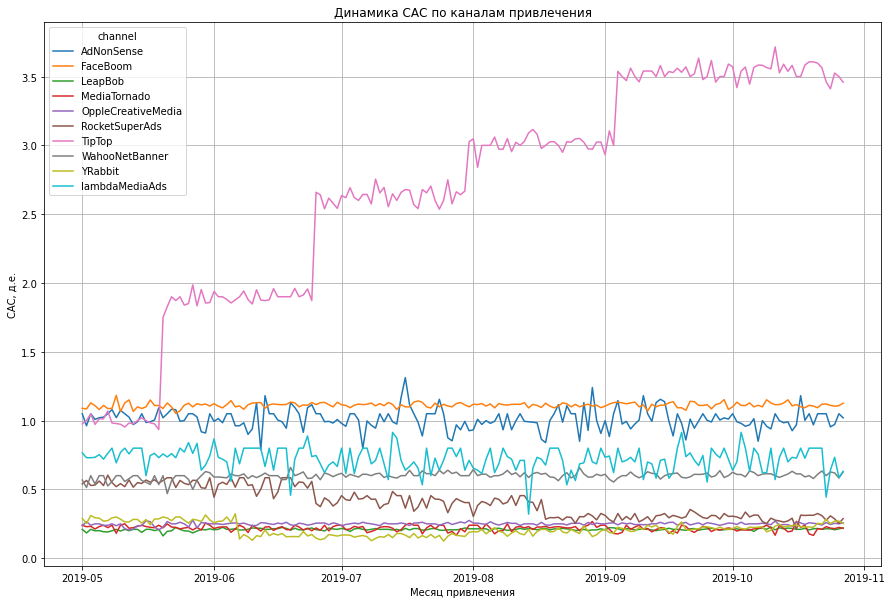

In [27]:
# строим график истории изменений CAC по каналам привлечения

profiles_without_organic.pivot_table(
    index='dt', columns='channel', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(15, 10))
plt.ylabel('CAC, д.е.')
plt.xlabel('Месяц привлечения')
plt.title('Динамика САС по каналам привлечения')
plt.show()

Удивительно какими темпами растет стоимость привлечения из TipTop и то, что этого не заметили раньше. С сентября по ноябрь мы тратим уже 3,5 д.е. на пользователя. А вот FaceBoom -красавчик, стабильно 1,1 д.е. Значит рост затрат идет исключительно за счет количества привлекаемых пользователей. AdNonSense и lambdaMediaAds на 3 и 4 месте по CAC. По ним пока окончательно сказать ничего нельзя.

### Вывод 

Общая сумма потраченных средств - 105497.3 д.е. из них половина ушла на закупку рекламы у TipTop -54751 д.е. Расходы на этот канал непрерывно растут, а CAC за это время вырос с 1 до 3,5 д.е. на конец исследуемого периода, но при этом привлеченных пользователей получили на 10 тысяч  меньше чем от FaceBoom, на который потрачено 32445.д.е. при стабильном CAC 1,1 д.е. Налицо дисбаланс в затратах. Как минимум стоит рассмотреть возможность переориентировать приоритет закупки трафика с TipTop на Faceboom. Но для начала посмотрим как обстоят дела с окупаемостью понесенных затрат.

##  Окупаемость рекламы для привлечения пользователей

Нам известно,что несмотря на огромные вложения в рекламу, и большой приток пользователей последние несколько месяцев компания терпит убытки. Чтобы разобраться в причинах ответим на следующие вопросы:
- Окупается ли реклама, направленная на привлечение пользователей в целом? 
- Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
- Чем могут быть вызваны проблемы окупаемости? 

Для этого необходимо:
- Проанализировать общую окупаемость рекламы;
- Проанализировать окупаемость рекламы с разбивкой по устройствам, странам, рекламным каналам;
- Изучить конверсию и удержание с разбивкой по устройствам, странам, рекламным каналам.


### Общая окупаемость рекламы

Для начала оценим общую ситуацию — посмотрим на окупаемость рекламы. Рассчитаем и визуализируем LTV и ROI, вызвав функции get_ltv() и plot_ltv_roi(). Чтобы не исказить данные, для расчетов будем использовать срез профилей без органческого трафика - "profiles_without_organic".

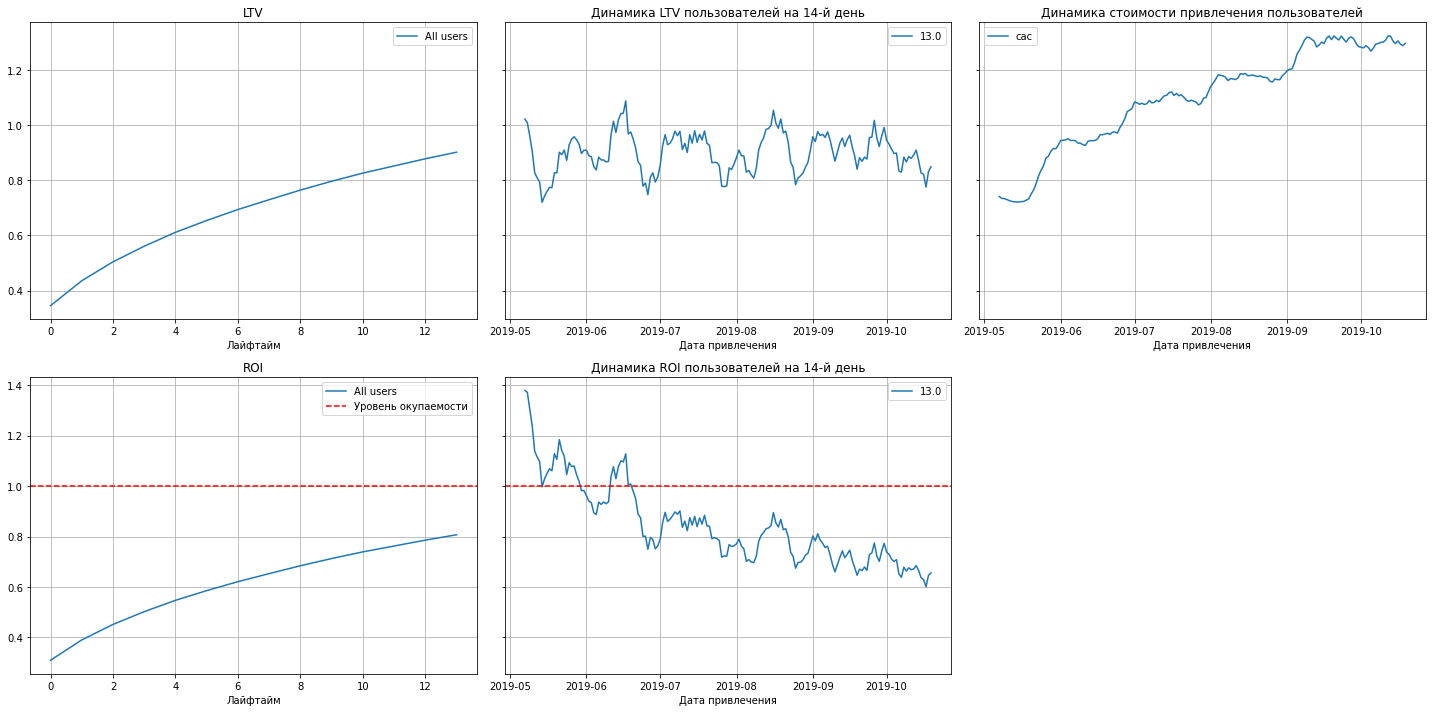

In [28]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_without_organic, orders, observation_date, horizon_days
)
# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

Изучив графики по общей окупаемости рекламы видим:

-  ROI на 14 день так и не достиг отметки окупаемости и еле дотянул до 0,8. Значит мы не отбиваем вложенные в привлечение пользователей денежные средства вопреки бизнес-плану где сказано, что пользователи должны окупаться не позднее чем через две недели.
-Если смотреть в динамике 14 дня, то ROI с самого начала стремительно снижался и уже через 2 недели был на грани отметки окупаемости. С середины июня уровень стабильно ниже окупаемости и продолжает снижаться.
- Вместе с тем мы видим, как со временем, от когорты к когорте, стремительно растет динамика CAC.

Можно сделать неутешительный вывод: расходы на привлечение пользователей не окупаются и ситуация имеет тенденцию к ухудшению. Есть предварительное предположение, что это связано с дорогим САС пользователей из TipTop. Рассмотрим подробнее ситуацию, проанализируем окупаемость рекламы в разрезе используемых устройств, канала привлечения и региона.

### Окупаемость рекламы с разбивкой по устройствам

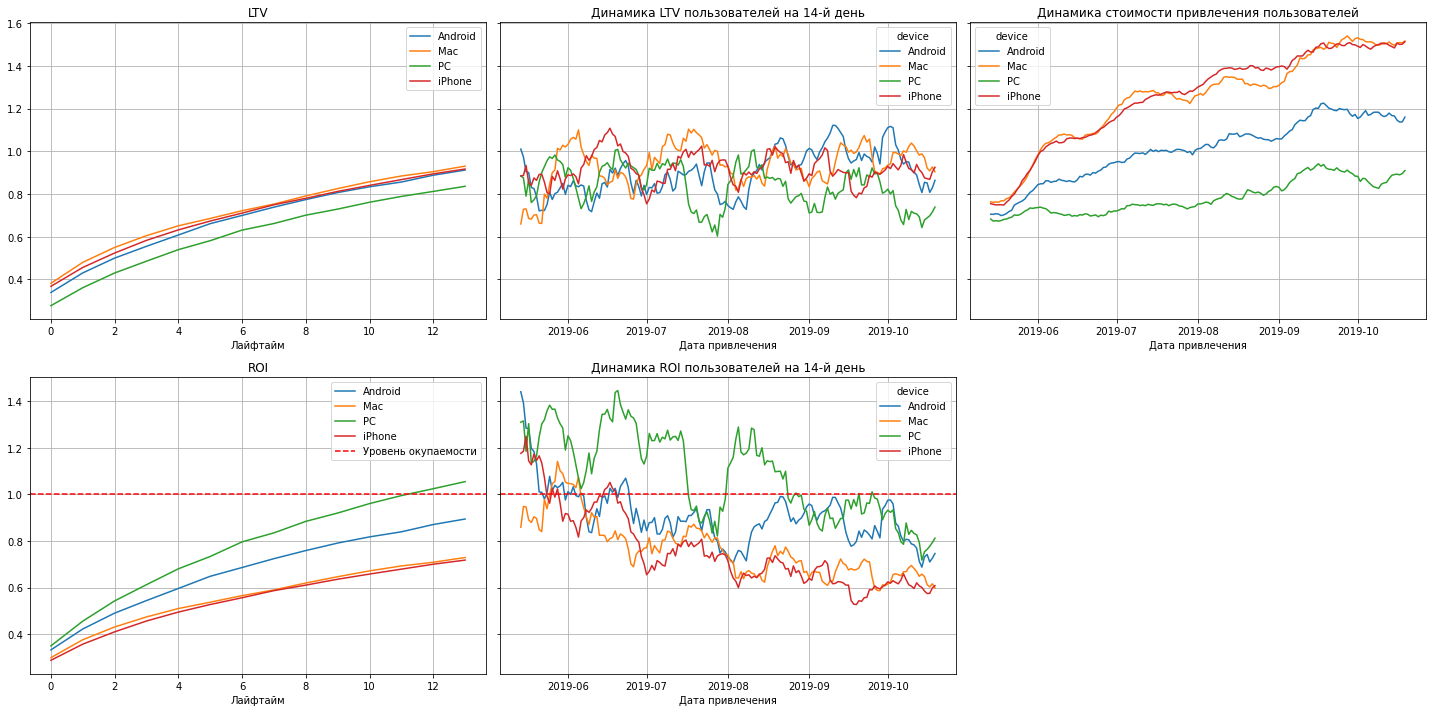

In [29]:
# смотрим окупаемость с разбивкой по устройствам

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_without_organic, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

По графику ROI видно, что реклама начинает окупаться только для пользователей PC на 12 день, но вряд ли это можно назвать успехом- показатель чуть выше 1. График динамики ROI для пользователей PC выглядит лучше, доходы были с мая до середины июля и почти весь август. 

ROI по всем когортам для остальных устройств так и не превысил порогового значения, однако график динамики показывет что в первый месяц мы и с этих устройств получали доход, но затем видим нарастающие убытки уже с середины июня. 

В общем при довольно схожем LTV по всем устройствам PC вышел в плюс только за счет стоимости привлечения пользователей. При относительно низком LTV CAC был тоже низким, но с ростом CAC и здесь ушли в минус.

###  Окупаемость рекламы с разбивкой по странам

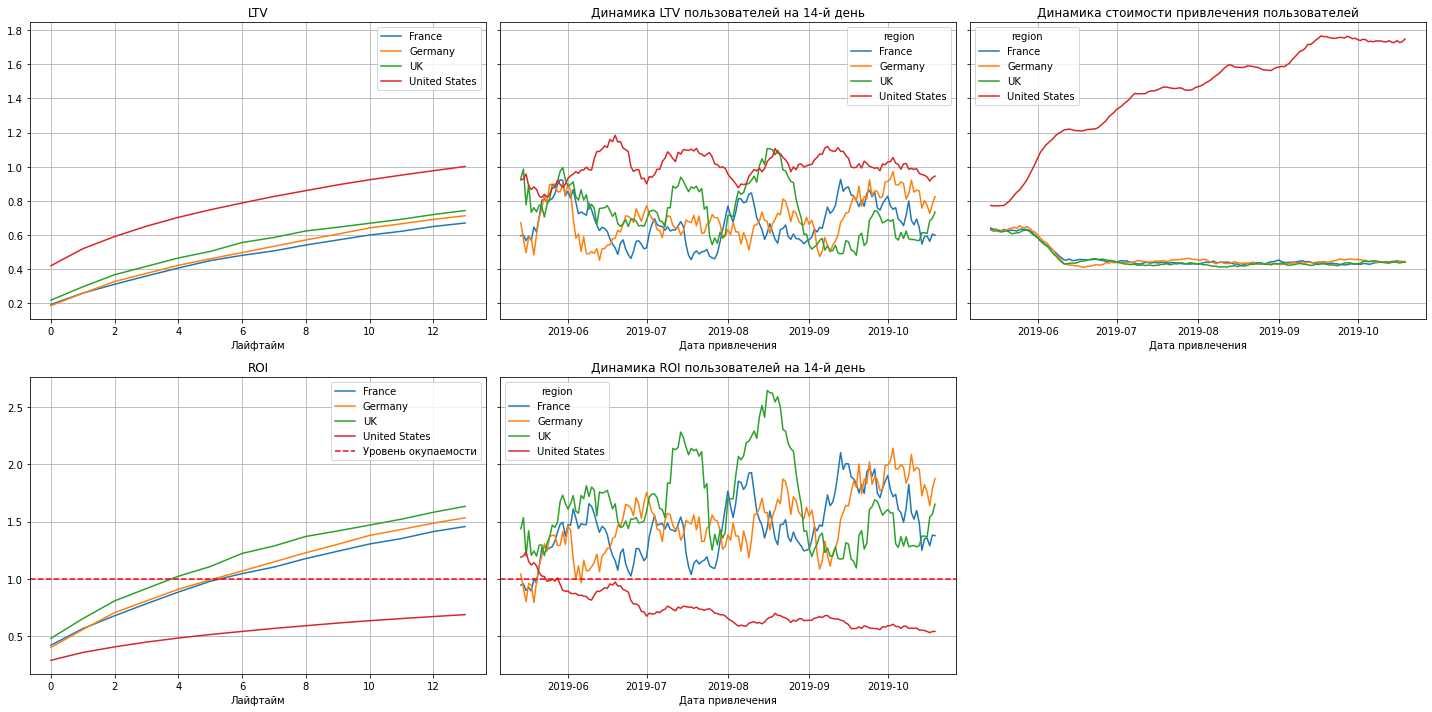

In [30]:
# смотрим окупаемость с разбивкой по странам

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_without_organic, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Интересно получилось. Оказывается больше всего денег нам приносят Американские пользователи- их LTV самый большой. На графике динамики LTV 14го дня,за редким исключением, их показатель стабильно выше остальных регионов.

Но график ROI говорит нам о том, что мы терпим убытки привлекая американцев. В динамике наблюдаем, как к июню ROI опустился до нуля, а затем закуп рекламы для этого региона перестал окупаться окончательно. 

Всё на свои места встает, если посмотреть на динамику CAC. Стоимость привлечения каждого пользователя из Америки стремится в космос, в то время как для остальных регионов  стоимость привлечения даже снизилась и осталась постоянно низкой.

Учитывая эти факторы стоит поговорить с маркетологами. Возможно зная, что пользователи из Америки самые многочисленные и имеют более высокий LTV, закупают дорогой трафик, не сильно беспокоясь о его цене, в надежде, что в долгосрочной перспективе эти траты себя оправдают.

### Окупаемость рекламы с разбивкой по рекламным каналам

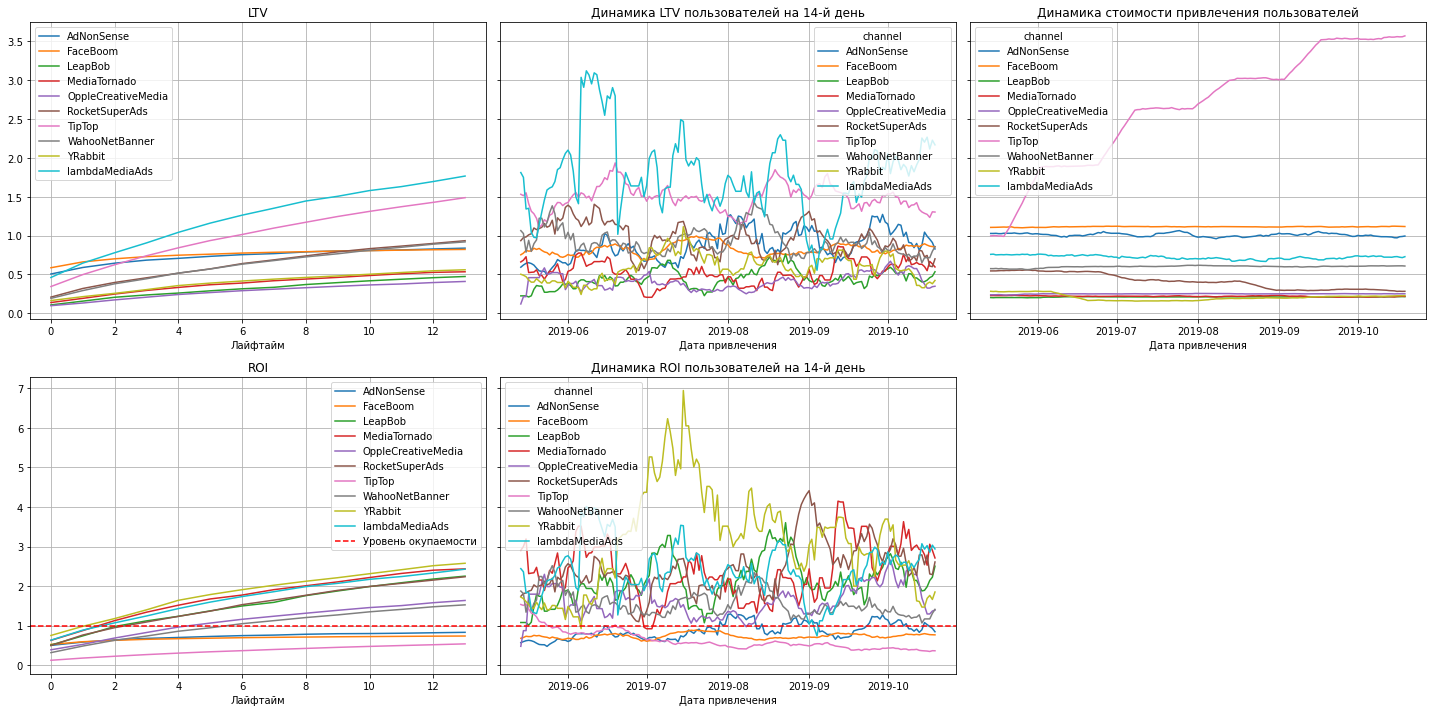

In [31]:
# смотрим окупаемость с разбивкой по источникам привлечения

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_without_organic, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Ранее мы уже обращали внимание на lambdaMediaAds, несмотря на относительно небольшое количество привлеченных пользователей - 2149, у этого канала хороший процент платящих- 10.5%. Теперь видим что пользователи, привлеченные lambdaMediaAds имеют самый высокий LTV, который в динамике довольно сильно колеблется, но все же приносит деньги. Окупаемость, судя по графику ROI, наступает уже на 3 день. Определенно стоит увеличивать долю этого канала в закупках трафика.

ROI, почти все каналы привлечения в итоге приносят доход. Уже на 2-7 день большинство преодалевают порог окупаемости. Хорошая динамика у YRabit, lambdaMediaAds, MediaTornado. Но есть 3 убыточных источника: маленький AdNonSense  и два гиганта, приводящие нам основную долю пользователей - TipTop и FaceBoom.

Не смотря на то, что на  втором месте по LTV находится TipTop и аудитория его велика, ROI за весь период исследования так и не привысил отметки окупаемости на 14 день(срок окупаемости, согласно бизнес-плану). Для нас этот источник закупки трафика убыточен постоянно. Всё дело в стоимости привлечения клиентов. Закупается очень дорогой трафик 3,5 д.е, при доходе с пользователя 1,5 д.е. 

Для FaceBoom LTV 14го дня не достигает 1 д.е, а на привлечение тратится 1,1 д.е. Получается, что на источник, который дает нам основной приток пользователей мы тратим больше, чем зарабатываем. Деньги стремительно утекают.

Посмотрим сколько денег из рекламного бюджета утекло на  FaceBoom и TipTop:

In [32]:
# делаем срезы по каналам и считаем суммы для каждого
cost_FaceBoom = profiles_without_organic.query('channel == "FaceBoom"')
cost_FaceBoom = cost_FaceBoom['acquisition_cost'].sum()

cost_TipTop = profiles_without_organic.query('channel == "TipTop"')
cost_TipTop = cost_TipTop['acquisition_cost'].sum()


display('Общая сумма потраченных средств - {} д.е.'.format(
                                                    round(all_cost, 1)
                                                          )
       )

display('Общая сумма потраченных средств на FaceBoom - {} д.е. в процентах  - {} %'.format(
                                                    round(cost_FaceBoom, 1), 
                                                    round(cost_FaceBoom / all_cost * 100, 1)
                                                          )
       )
display('Общая сумма потраченных средств на TipTop - {} д.е. в процентах  - {} %'.format(
                                                    round(cost_TipTop, 1),
                                                    round(cost_TipTop / all_cost * 100, 1)
                                                          )
       )
display('Слито бюджета на FaceBoom и TipTop - {} %'.format(
                                                    round(cost_TipTop / all_cost * 100 + cost_FaceBoom / all_cost * 100, 1)
                                      )
       )

'Общая сумма потраченных средств - 105497.3 д.е.'

'Общая сумма потраченных средств на FaceBoom - 32445.6 д.е. в процентах  - 30.8 %'

'Общая сумма потраченных средств на TipTop - 54751.3 д.е. в процентах  - 51.9 %'

'Слито бюджета на FaceBoom и TipTop - 82.7 %'

### Вывод
Изучив общую окупаемость за весь исследуемый период с мая по ноябрь 2019 года нашли, что с июня сильно увеличилась стоимость привлечения клиентов(CAC), это в свою очередь привело к падению ROI в динамике. Общий ROI за весь период так и не достиг уровня окупаемости. Компания теряет деньги, тренд нисходящий.

Рассмотрев LTV, CAC и ROI  в разрезе используемых устройств, каналов привлечения и регионов получили портрет типичного пользователя. Это американец, использующий iPhone или Mac, пришедший к нам через TipTop или FaceBoom. Исследовав графики пришли к следующему выводу. Основной проблемой является неоправдано дорогой закуп рекламы в двух рекламных источниках, которые приводят к нам основную массу пользователей- TipTop и FaceBoom. Расходы на привлечение через TipTop и FaceBoom выше доходов. Компания терпит большие убытки. Из общего рекламного бюджета 105497.3 д.е. 82.7% потрачено впустую. Необходимо снижать затраты на привлечение через эти каналы, вплоть до полного отказа от закупа. Имеет смысл разработать метрику, отслеживающую для них изменение LTV в коротком периоде, скажем в 7 дней, и выводящую рекомендованную максимальную цену для закупа нового трафика.

Стоит также обратить внимание на более мелкие каналы привлечения, такие как YRabit, lambdaMediaAds, MediaTornado, которые стабильно приносят небольшой доход, и увеличивать их долю в закупе трафика.

С привлечением пользователей разобрались. Осталось рассмотреть как привлеченные пользователи удерживаются и какие тут могут быть проблемы.

###  Конверсия и удержание пользователей

В ходе исследования постараемся ответить на следующие вопросы:
- Какие устройства, страны и каналы могут снижать окупаемость рекламы;
- Чем могут быть вызваны проблемы окупаемости.

Построим и изучим графики конверсии и удержания с разбивкой по устройствам, странам, рекламным каналам.

С помощью функций get_conversion и plot_conversion  расчитаем конверсию и визуализируем ее на графиках. Начнем с конверсии по устройствам.

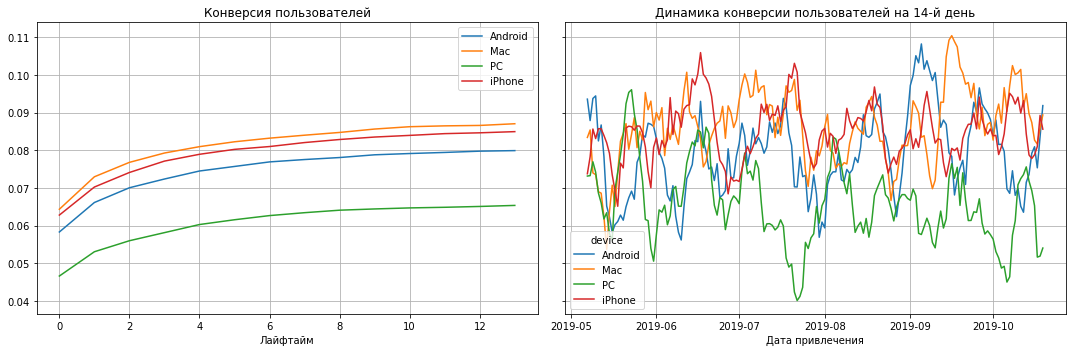

In [33]:
# смотрим конверсию с разбивкой по устройствам
dimensions = ['device']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_without_organic, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

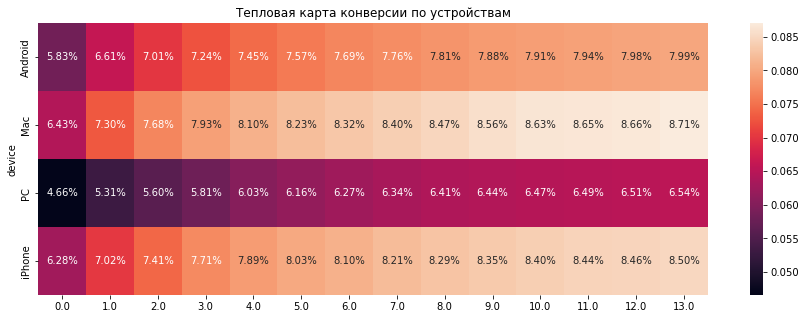

In [34]:
# строим тепловую карту конверсии
plt.figure(figsize=(15, 5))
sns.heatmap(conversion_grouped.drop(columns=['cohort_size']), annot=True, fmt='.2%')
plt.title('Тепловая карта конверсии по устройствам')
plt.show() 

Судя по графикам, пользователи iPhone и MAC конвертируются лучше других. На 14 день конверсия MAC - 8,71%, у iPhone - 8,5%. Динамика конверсий не стабильна для всех устройств.

Выделяются пользователи PC- их конверсия ниже чем у остальных - 6,54% и в динамике есть периоды, когда конверсия приближается к нулю. Это не похоже на сезонность т.к. в это время конверсия по другим устройствам растет. Возможно есть проблемы в работе приложения именно для PC.

Вызовем функции get_retention() и plot_retention(), чтобы рассчитать и отразить на графиках удержание пользователей с разделением по устройствам. Отдельно посмотрим на платящих и не платящих пользователей.

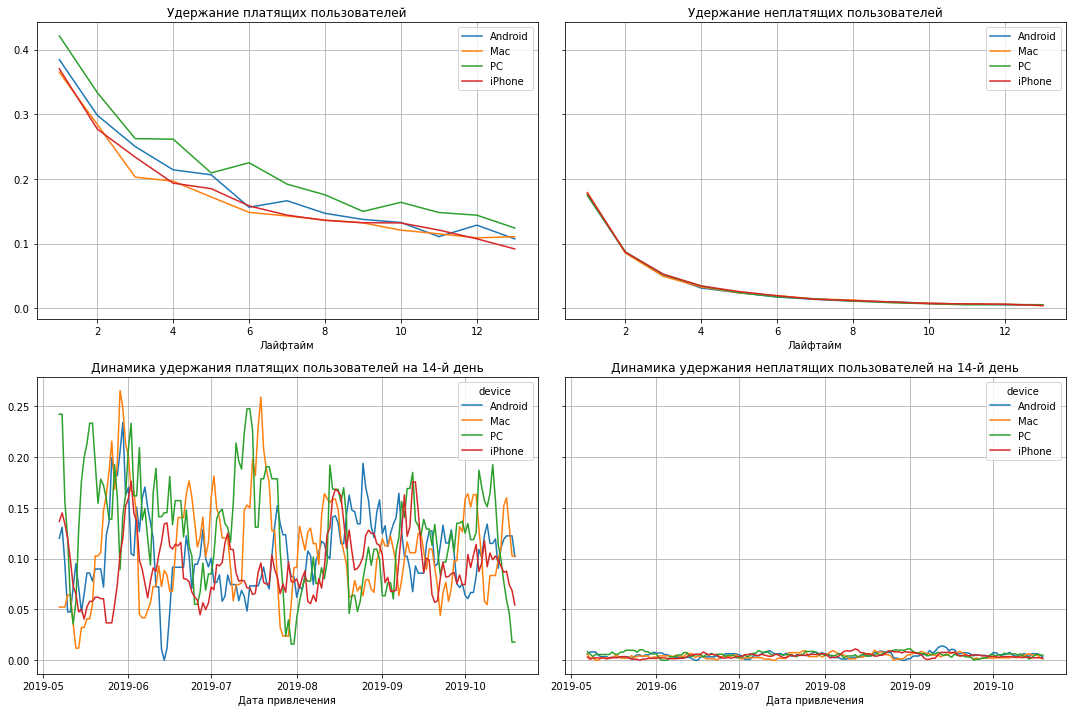

In [35]:
# смотрим удержание с разбивкой по устройствам 

retention_raw, retention_grouped, retention_history = get_retention(
    profiles_without_organic, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Неплатящие пользователи ведут себя дружно и стабильно плохо удерживаются. 

Среди платящих пользователи PC удерживаются немнго лучше других, особенно показатель был хорош в начале исследуемого периода. По графику динамики видно сильное колебание показателя удржания пользователей MAC и PC. Возможно наше приложение  для них работает не стабильно. Стоит покопаться в логах ошибок работы приложения.

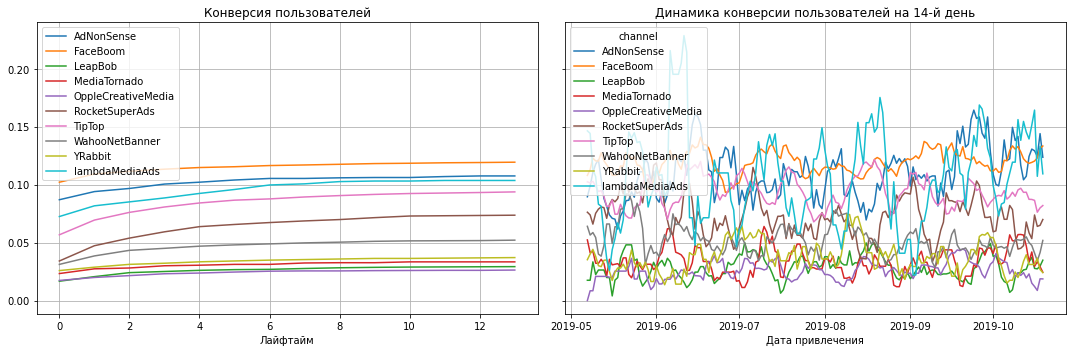

In [36]:
# смотрим конверсию с разбивкой по каналам
dimensions = ['channel']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_without_organic, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

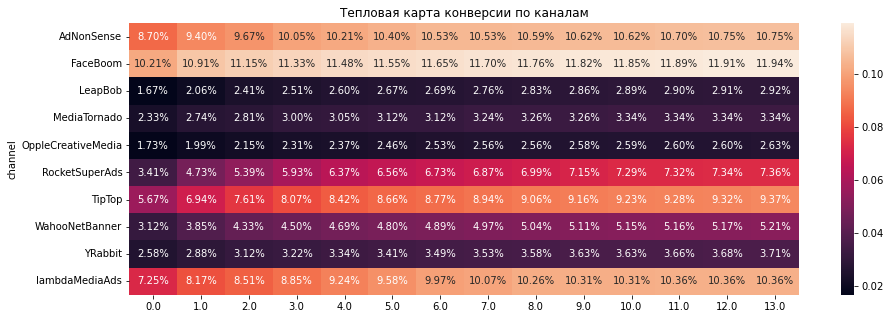

In [37]:
# строим тепловую карту конверсии
plt.figure(figsize=(15, 5))
sns.heatmap(conversion_grouped.drop(columns=['cohort_size']), annot=True, fmt='.2%')
plt.title('Тепловая карта конверсии по каналам')
plt.show() 

Очень слабая конверсия, помимо органических пользователей, еще у трех источников. На 14 день: LeapBob - 2,92%, MediaTornado - 3.34% и OppleCreativeMedia - 2.63%. Но не смотря на этот факт, ROI у них всё же положительный, поэтому стоит оставить эти каналы.

Хорошо показывает себя FaceBoom -его конверсия самая высокая, пользователи с 1го дня хорошо конвертируются в покупателей- 10,21% , но к 14 дню прирост небольшой - 11,94%. В динамике конверсия довольно стабильна.

У TipTop показатель конверсии слабее, на 1й день 5,67%, на 14 день 9,37%, в динамике подвержен сильным колебаниям. 

Так же хорошие показатели на 14 день имеют AdNonSence - 10.75%  и LambdaMediaAds - 10.36%. 

Посмотрим как обстоят дела с удержанием.

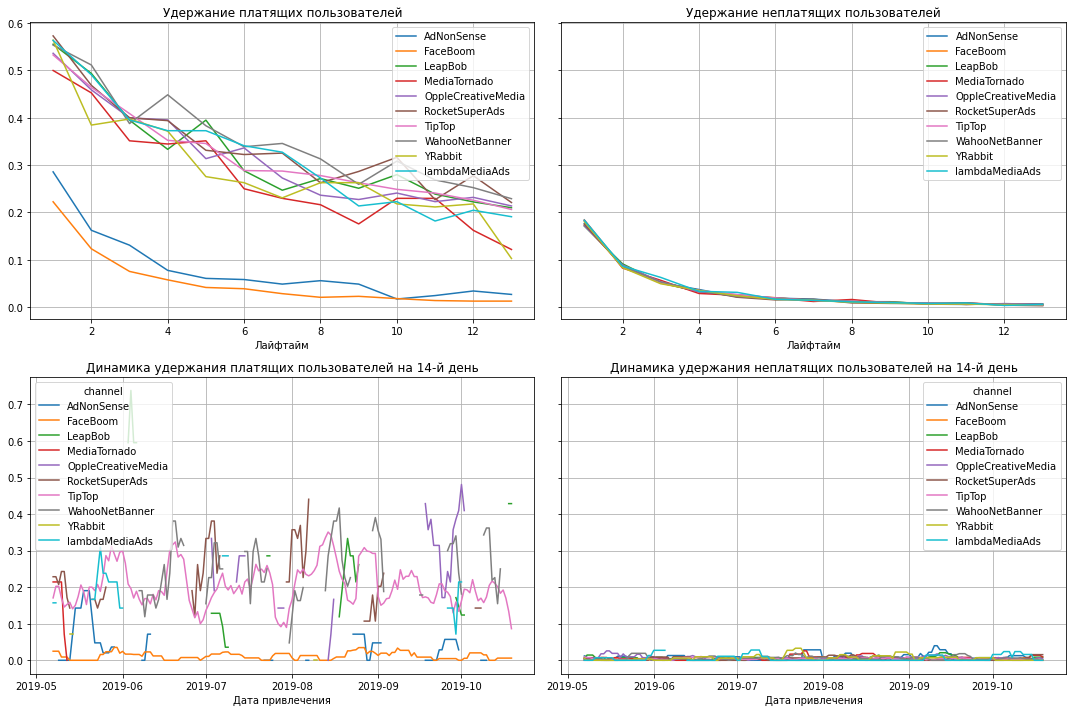

In [38]:
# смотрим удержание с разбивкой по каналам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles_without_organic, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Кажется нашли еще проблему. Удержание пользователей FaceBoom за всё время гораздо слабее,чем у других. На графике динамики удержания платящих пользователей видим, что за весь период показатель слабо колеблется в районе нуля.  Мы привлекли самую большую долю клиентов через этот источник, но тут же их потеряли. Получается деньги на привлечение через FaceBoom потрачены впустую, а это 30% рекламного бюджета.
На графике также наблюдаем прерывистые линии по другим источникам, кажется они просто не "доживают" до 14го дня. В частности для AdNonSense. Посмотрим на срез данных по этому источнику, чтобы понять причину. 

In [39]:
retention_history

cohort_size    0         1         2  \
payer channel        dt                                                 
False AdNonSense     2019-05-01           36  1.0  0.222222  0.000000   
                     2019-05-02           36  1.0  0.111111  0.083333   
                     2019-05-03           42  1.0  0.142857  0.095238   
                     2019-05-04           45  1.0  0.133333  0.066667   
                     2019-05-05           31  1.0  0.322581  0.064516   
...                                      ...  ...       ...       ...   
True  lambdaMediaAds 2019-10-13            2  1.0  1.000000  0.500000   
                     2019-10-14            1  1.0  0.000000  1.000000   
                     2019-10-15            3  1.0  0.666667  0.666667   
                     2019-10-16            1  1.0  1.000000  0.000000   
                     2019-10-18            2  1.0  1.000000  1.000000   

                                        3         4         5         6  \
payer channel        dt                                                   
False AdNonSense     2019-05-01  0.111111  0.027778  0.000000  0.027778   
                     2019-05-02  0.027778  0.027778  0.000000  0.055556   
                     2019-05-03  0.047619  0.023810  0.023810  0.047619   
                     2019-05-04  0.044444  0.022222  0.022222  0.000000   
                     2019-05-05  0.064516  0.032258  0.000000  0.032258   
...                                   ...       ...       ...       ...   
True  lambdaMediaAds 2019-10-13  0.000000  1.000000  0.500000  0.500000   
                     2019-10-14  0.000000  0.000000  0.000000  1.000000   
                     2019-10-15  0.666667  0.333333  0.333333  0.333333   
                     2019-10-16  1.000000  0.000000  0.000000  0.000000   
                     2019-10-18  1.000000  0.000000  0.000000  0.000000   

                                       7         8         9        10  \
payer channel        dt                                                  
False AdNonSense     2019-05-01  0.00000  0.000000  0.027778  0.000000   
                     2019-05-02  0.00000  0.055556  0.000000  0.000000   
                     2019-05-03  0.02381  0.000000  0.000000  0.000000   
                     2019-05-04  0.00000  0.000000  0.000000  0.000000   
                     2019-05-05  0.00000  0.000000  0.000000  0.000000   
...                                  ...       ...       ...       ...   
True  lambdaMediaAds 2019-10-13  0.00000  0.500000  0.000000  0.000000   
                     2019-10-14  0.00000  0.000000  1.000000  0.000000   
                     2019-10-15  0.00000  0.333333  0.000000  0.333333   
                     2019-10-16  1.00000  0.000000  0.000000  0.000000   
                     2019-10-18  0.50000  1.000000  0.500000  0.500000   

                                       11        12        13  
payer channel        dt                                        
False AdNonSense     2019-05-01  0.000000  0.000000  0.027778  
                     2019-05-02  0.055556  0.055556  0.027778  
                     2019-05-03  0.000000  0.000000  0.000000  
                     2019-05-04  0.000000  0.000000  0.000000  
                     2019-05-05  0.000000  0.000000  0.000000  
...                                   ...       ...       ...  
True  lambdaMediaAds 2019-10-13  0.000000  0.500000  0.000000  
                     2019-10-14  1.000000  0.000000  1.000000  
                     2019-10-15  0.333333  0.000000  0.666667  
                     2019-10-16  0.000000  0.000000  0.000000  
                     2019-10-18  0.500000  0.000000  0.500000  

[3082 rows x 15 columns]

In [40]:
# срез по каналу LeapBob. Платящие клиенты с 1 мая по 31 июля
x = retention_history.reset_index()
x['dt'] = pd.to_datetime(x['dt'])
x.query('channel =="AdNonSense" and payer ==True and "2019-05-01"< dt < "2019-07-31"')

,payer,channel,dt,cohort_size,0,1,2,3,4,5,6,7,8,9,10,11,12,13
1720,True,AdNonSense,2019-05-03,3,1.0,0.666667,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.333333,0.000000,0.0
1721,True,AdNonSense,2019-05-04,6,1.0,0.166667,0.166667,0.0,0.0,0.000000,0.166667,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
1722,True,AdNonSense,2019-05-05,5,1.0,0.200000,0.000000,0.2,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.200000,0.0
1723,True,AdNonSense,2019-05-06,6,1.0,0.166667,0.166667,0.0,0.0,0.166667,0.000000,0.0,0.0,0.333333,0.166667,0.000000,0.166667,0.0
1724,True,AdNonSense,2019-05-07,3,1.0,0.333333,0.333333,0.0,0.0,0.000000,0.333333,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1793,True,AdNonSense,2019-07-24,2,1.0,0.500000,0.500000,0.5,0.0,0.000000,0.000000,0.5,0.0,0.000000,0.000000,0.000000,0.000000,0.0
1794,True,AdNonSense,2019-07-25,2,1.0,0.500000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.5,0.000000,0.000000,0.000000,0.000000,0.0
1795,True,AdNonSense,2019-07-27,2,1.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
1796,True,AdNonSense,2019-07-28,1,1.0,0.000000,1.000000,1.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0


Да, видим нулевые значения на 14 день, значит данные в порядке. Но это же означает, что мы теряем большинство пользователей из когорт до истечения двух недель. Имеем явные проблемы с удержанием. Еще одна причина почему расходы на привлечение не окупаются.

Здесь вполне возможно неверно настроен таргет и мы привлекаем нецелевую аудиторию.

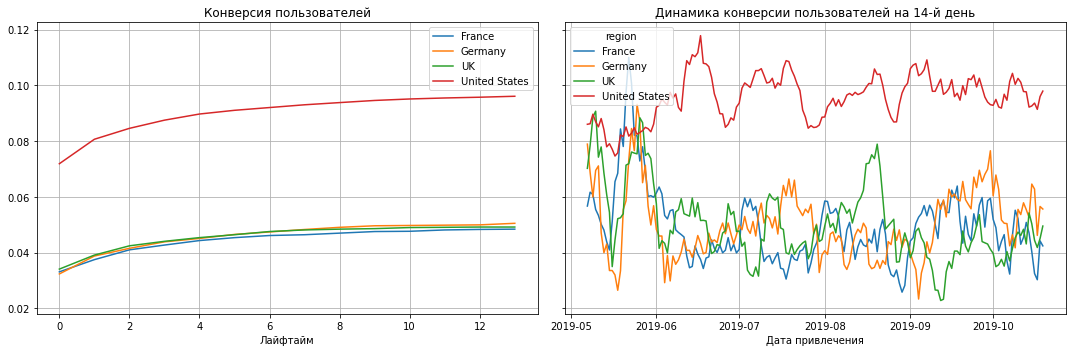

In [41]:
# смотрим конверсию с разбивкой по регионам
dimensions = ['region']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_without_organic, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

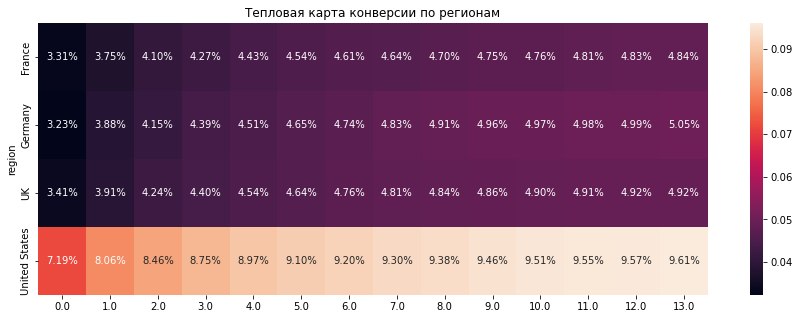

In [42]:
plt.figure(figsize=(15, 5))
sns.heatmap(conversion_grouped.drop(columns=['cohort_size']), annot=True, fmt='.2%')
plt.title('Тепловая карта конверсии по регионам')
plt.show() 

Американцы- основной сегмент пользователей лучше других конвертируются в клиентов - 9,61% на 14 день. Это уже можно было предположить зная, что самая лучшая конверсия по устройствам у iPhone и MAC и по источникам FaceBoom и TipTop. Сюрприза нет, еще одно подтверждение теории, что это наш типичный пользователь.

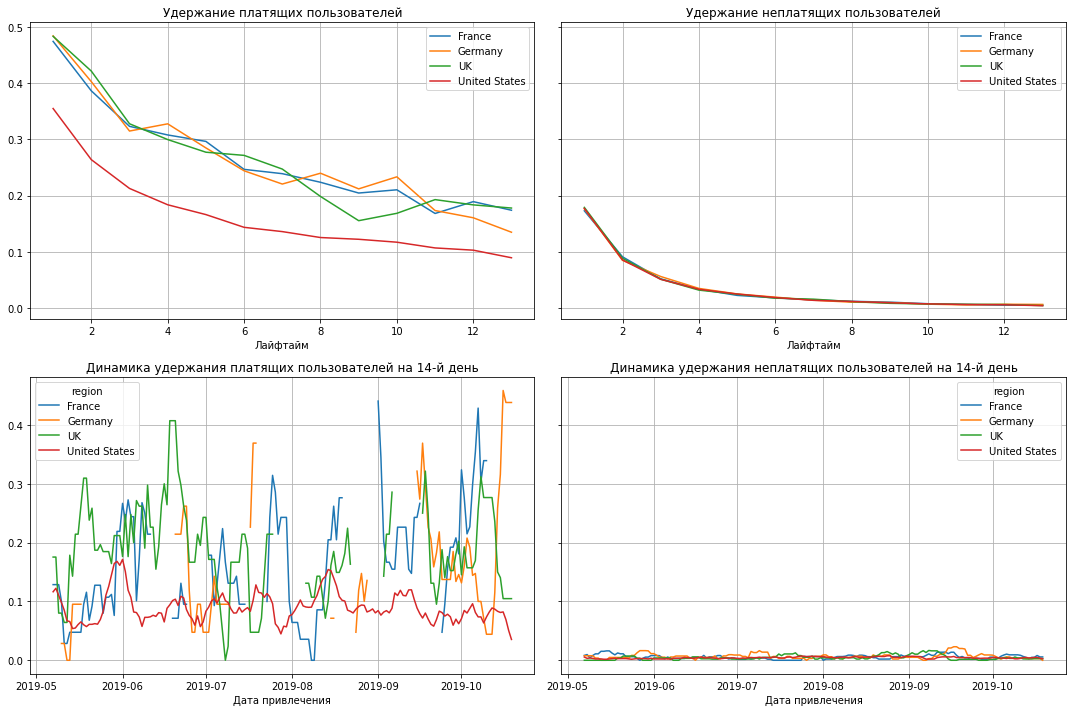

In [43]:
# смотрим удержание с разбивкой по регионам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles_without_organic, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Американцы гораздо лучше остальных конвертируются, но при этом слабо удерживаются. Нужно искать причины в работе нашего приложения с американским сегментом. Возможно для них оно работает нестабильно или некорректно. В целом по всем остальным регионам динамика удержания сильно колеблется, возможно и для остальных регионов есть проблемы в работе приложения.

### Вывод

Изучив конверсию и удержание в разрезе используемых устройств, источников привлечения и регионов нашли, что пользователи хорошо конвертируются, но плохо удерживаются, временами когорты не доживают до 14 дня. 

Очень плохой показатель удержания у FaceBoom- в динамике за всё время показатель слабо колеблется в районе нуля. Это в свою очередь влияет на показатель удержания для Американского рынка, для которого типично использование iPhone и MAC, и популярными сервисами являются FaceBoom и TipTop. 

Необходимо более тщательно изучать вопрос нестабильного и слабого удержания пользователей, в работе приложения определенно есть проблемы. По некоторым источникам наблюдается слабое удержание когорт, скорее всего неверно настроен таргет.

# Общий вывод



В нашем распоряжении была информация о пользователях, привлечённых с 1 мая по 27 октября 2019 года, с данными об их посещениях, истории покупок за этот период  а также данные о понесенных рекламных расходах.

Необходимо было выяснить почему компания терпит убытки.

В ходе исследования удалось выяснить, что к нам пришло чуть более 150 тысяч пользователей, 100 тысяч из них- американцы. Остальные, примерно в равном соотношении, Французы и Англичане(по 17,5 тысяч) и Немцы(14,9 тысяч). Чаще всего к нам в приложение заходят с мобильных устройств 54479 пользователей с iPhone и  35032 с Android. Чуть реже с компьютеров PC - 30455 и Mac- 30042. У пользователей с iPhone и Mac самое большое соотношение платящих 6,2% и 6,4%. 

Треть пользователей нашла нас сама, через органический трафик- 56,5 тысяч человек. Из платных больше всех привлекли FaceBoom 29,1 тысячи чел. и TipTop- 19,5 чел. Для верного расчета экономических показателей мы в ходе исследования сосредоточились на пользователях, которых привлекали с помощью платных источников, исключив из данных органический трафик. 

Общая сумма потраченных средств - 105497.3 д.е. из них половина ушла на закупку рекламы у TipTop -54751 д.е. Расходы на этот канал непрерывно растут, а CAC за это время вырос с 1 до 3,5 д.е. на конец исследуемого периода. На FaceBoom,  потрачено 32445.д.е. при стабильном CAC 1,1 д.е.

Изучив общую окупаемость за весь исследуемый нашли, что с июня сильно увеличилась стоимость привлечения клиентов(CAC), это в свою очередь привело к падению ROI в динамике. Общий ROI за весь период так и не достиг уровня окупаемости. Компания теряет деньги и ситуация только ухудшается.

Рассмотрев LTV, CAC и ROI в разрезе используемых устройств, каналов привлечения и регионов получили портрет типичного пользователя. Это американец, использующий iPhone или Mac, пришедший к нам через TipTop или FaceBoom. Исследовав графики пришли к следующему выводу. Основной проблемой является неоправдано дорогой закуп рекламы в двух рекламных источниках, которые приводят к нам основную массу пользователей- TipTop и FaceBoom. Расходы на привлечение через TipTop и FaceBoom выше доходов -ROI отрицательный. 

Изучив конверсию и удержание в разрезе используемых устройств, источников привлечения и регионов нашли, что пользователи хорошо конвертируются, но довольно плохо удерживаются. Особенно это касается американского рынка, для которого типично использование устройси Apple, и популярными сервисами являются FaceBoom и TipTop. Удержание пользователей FaceBoom за всё время гораздо слабее,чем у других. За весь изучаемый период показатель слабо колеблется в районе нуля. Причины этого явления не понятны, нужна дополнительная информация. Однако, этот факт дает нам основание отказаться от размещения рекламы в этом источнике, по крайней мере до выяснения обстоятельств.

Есть предположение, что для американского региона существуют проблемы в работе приложения, но имеющихся данных не достаточно чтобы сформулировать в чем они заключаются. Не понятно также почему именно у FaceBoom удержание запредельно низкое. 
 По другим источникам увидели пробелы в графиках, а это означает, что пользователи не "доживают" до 14го дня.
 
Получается мы прокачиваем через приложение большое количество пользователей, тратя попутно на их привлечение много денег, но пользователи покидают нас не успев окупиться. Из общего рекламного бюджета (105497.3 д.е.) 82.7% потрачено впустую. 

Как итог:

- Главная проблема -  закуп дорогой рекламы у  FaceBoom и TipTop, которые приводят основную массу пользователей, ROI отрицательный;
- Слабое и нестабильное удержание пользователей, когорты не доживают до расчетного в бизнес-плане срока окупаемости, 
- В работе приложения скорее всего есть проблемы.

# Рекомендации

Для повышения эффективности отделу маркетинга можно дать следующие рекомендации:

- Сейчас отказаться от привлечения через все 3 убыточных источника TipTop, FaceBoom и AdNonSense;
- Разработать метрику максимальной рекомендуемой цены для закупа нового трафика, ориентируясь на ROI источника в коротком периоде 3-7 дней;
- Изучить логи ошибок, построить воронки, переговорить с техподдержкой, почитать отзывы пользователей, в общем выяснить что не так с удержанием пользователей и в частности FaceBoom;
- Перепроверить настройки таргета по источникам привлечения, у которых короткий lifetime пользователей;
- Стоит обратить внимание на более мелкие каналы привлечения, такие как lambdaMediaAds, которые стабильно приносят небольшой доход, и увеличивать их долю в закупе трафика.


